In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import json
%matplotlib inline


In [ ]:

# na_filter = False -> None nao é um missing value
energia21 = pd.read_csv('./energia_202109-202112.csv', encoding='latin-1', na_filter=False)
energia22 = pd.read_csv('./energia_202201-202212.csv', encoding='latin-1',na_filter=False)

meteo21 = pd.read_csv('./meteo_202109-202112.csv', encoding='latin-1')
meteo22 = pd.read_csv('./meteo_202201-202212.csv', encoding='latin-1')

test_energia = pd.read_csv('./energia_202301-202304.csv', encoding='latin-1', na_filter=False)
test_meteo = pd.read_csv('./meteo_202301-202304.csv', encoding='latin-1', na_filter=False)


### Merge datasets

In [ ]:
energiaDatasets = pd.concat([energia21, energia22])
energiaDatasets.to_csv("combinedEnergia.csv", index=False)

In [ ]:
energiaDatasets.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,None
1,2021-09-29,1,0.0,0.0,0.0,None
2,2021-09-29,2,0.0,0.0,0.0,None
3,2021-09-29,3,0.0,0.0,0.0,None
4,2021-09-29,4,0.0,0.0,0.0,None


<Axes: >

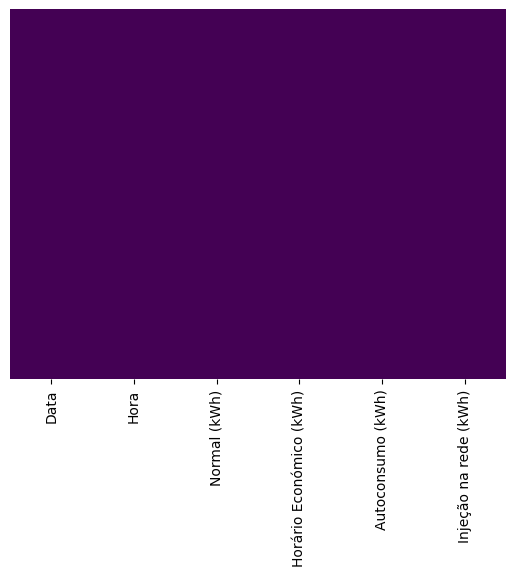

In [ ]:
sns.heatmap(energiaDatasets.isnull(), yticklabels = False, cbar=False, cmap='viridis')

In [ ]:
energiaDatasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11016 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 602.4+ KB


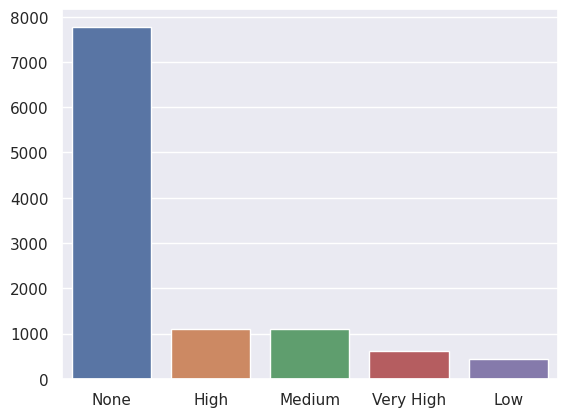

In [ ]:
inj_count = energiaDatasets['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
sns.barplot(x=inj_count.index, y=inj_count.values)
plt.show()

In [ ]:
'''
nova coluna para a injeção na rede ter valores
None-0, Low-1, Medium-2, High-3, Very High-4
'''
column_mapping = {
    'Injeção na rede (kWh)': {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
}
for column, mapping in column_mapping.items():
    energiaDatasets[column] = energiaDatasets[column].map(mapping)

energiaDatasets.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,0
1,2021-09-29,1,0.0,0.0,0.0,0
2,2021-09-29,2,0.0,0.0,0.0,0
3,2021-09-29,3,0.0,0.0,0.0,0
4,2021-09-29,4,0.0,0.0,0.0,0


### combine datasets de metereologia

In [ ]:
# Merge the two dataframes
meteoDatasets = pd.concat([meteo21, meteo22])

meteoDatasets.to_csv("combinedMeteo.csv", index=False)

In [ ]:
meteoDatasets.isnull().sum()

dt                         0
dt_iso                     0
city_name                  0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              11688
grnd_level             11688
humidity                   0
wind_speed                 0
rain_1h                 9253
clouds_all                 0
weather_description        0
dtype: int64

<Axes: >

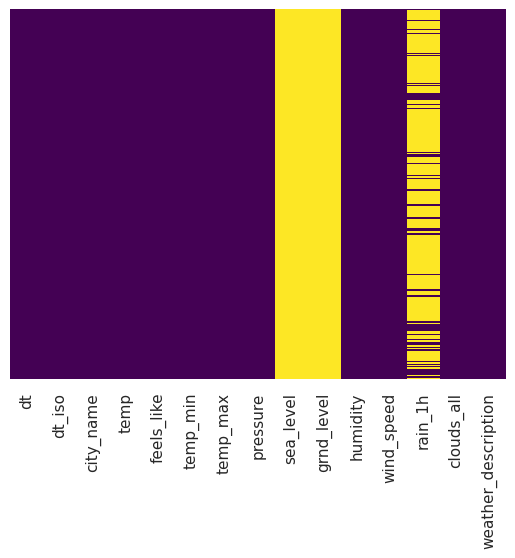

In [ ]:
sns.heatmap(meteoDatasets.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
meteoDatasets.nunique()

dt                     11688
dt_iso                 11688
city_name                  1
temp                    2423
feels_like              2702
temp_min                 488
temp_max                 550
pressure                  41
sea_level                  0
grnd_level                 0
humidity                  82
wind_speed               771
rain_1h                  371
clouds_all               101
weather_description        8
dtype: int64

In [ ]:
meteoDatasets.drop(['sea_level','grnd_level','city_name'], axis=1,inplace=True)

In [ ]:
test_meteo.drop(['sea_level','grnd_level','city_name'], axis=1,inplace=True)

In [ ]:
meteoDatasets['rain_1h'].describe()

count    2435.000000
mean        0.884760
std         1.073453
min         0.100000
25%         0.210000
50%         0.450000
75%         1.070000
max         7.450000
Name: rain_1h, dtype: float64

In [ ]:
meteoDatasets['rain_1h'].skew()

2.456975261874293

In [ ]:
test_meteo['rain_1h'] = test_meteo['rain_1h'].replace('', pd.NA)


In [ ]:
test_meteo['rain_1h'] = test_meteo['rain_1h'].fillna(0.0)
meteoDatasets['rain_1h'] = meteoDatasets['rain_1h'].fillna(0.0)

# Converter a coluna de objeto para float
test_meteo['rain_1h'] = test_meteo['rain_1h'].astype(float)

### check standart deviation

In [ ]:
#std = meteoDatasets.std().round(2).sort_values(ascending=False)
#std_test = test_meteo.std().round(2).sort_values(ascending=False)


### check skewed distribuition

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

In [ ]:
old_skew = meteoDatasets.skew().sort_values(ascending=False)
old_skew_test = test_meteo.skew().sort_values(ascending=False)


<ipython-input-21-e88e915ab549>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  old_skew = meteoDatasets.skew().sort_values(ascending=False)
<ipython-input-21-e88e915ab549>:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  old_skew_test = test_meteo.skew().sort_values(ascending=False)


In [ ]:
def logTrans(feature):   # function to apply transformer and check the distribution with histogram and kdeplot

    logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), [feature])])

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=15)
    sns.histplot(meteoDatasets[feature], kde=True, color="red")
    plt.subplot(1,2,2)

    df_log = pd.DataFrame(logTr.fit_transform(meteoDatasets))
    plt.title("Distribution after Transformation", fontsize=15)
    sns.histplot(df_log,bins=20, kde=True , legend=False)
    plt.xlabel(feature)
    plt.show()

    print(f"Skewness was {round(old_skew[feature],2)} before & is {round(df_log.skew()[0],2)} after Log transformation.")


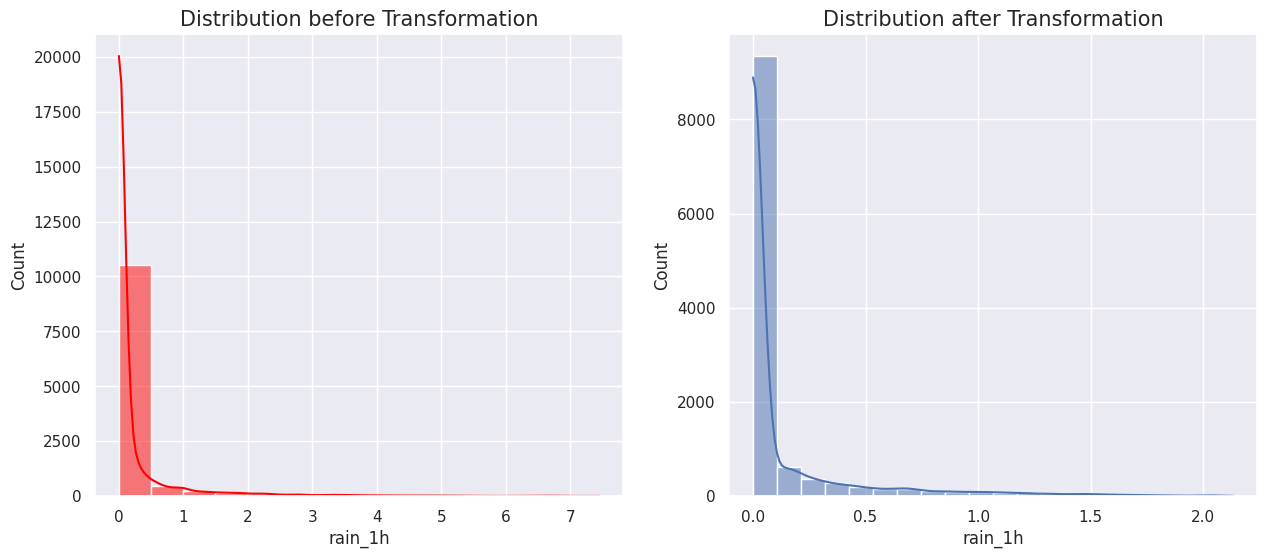

Skewness was 5.37 before & is 3.39 after Log transformation.


In [ ]:
logTrans(feature="rain_1h")

Mesmo após aplicar uma transformação logarítmica o valor continua elevado e com uma concentração à esquerda. Achamos melhor remover estas colunas.

In [ ]:
test_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   1752 non-null   int64  
 1   dt_iso               1752 non-null   object 
 2   temp                 1752 non-null   float64
 3   feels_like           1752 non-null   float64
 4   temp_min             1752 non-null   float64
 5   temp_max             1752 non-null   float64
 6   pressure             1752 non-null   int64  
 7   humidity             1752 non-null   int64  
 8   wind_speed           1752 non-null   float64
 9   rain_1h              1752 non-null   float64
 10  clouds_all           1752 non-null   int64  
 11  weather_description  1752 non-null   object 
dtypes: float64(6), int64(4), object(2)
memory usage: 164.4+ KB


In [ ]:
meteoDatasets['weather_description'].unique()

array(['broken clouds', 'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'scattered clouds', 'sky is clear',
       'few clouds'], dtype=object)

In [ ]:
column_mapping = {
    'weather_description': {'heavy intensity rain': 0, 'moderate rain':1, 'light rain':2, 'overcast clouds':3, 'scattered clouds':4, 'broken clouds':5, 'few clouds':6, 'sky is clear':7},
}
for column, mapping in column_mapping.items():
    meteoDatasets[column] = meteoDatasets[column].replace(mapping)
    test_meteo[column] = test_meteo[column].replace(mapping)

In [ ]:
test_meteo['weather_description'].unique()

array([1, 0, 2, 3, 4, 6, 7, 5])

### Weather Description and clouds correlation


#### Light Rain

In [ ]:
#filtered_df = meteoDatasets[(meteoDatasets['weather_description'] == 1) & (meteoDatasets['clouds_all'] < 20)]

# Printing clouds_all values of the filtered rows
#print(filtered_df['clouds_all'].values)

In [ ]:
#correlation = meteoDatasets['weather_description'].corr(meteoDatasets['clouds_all'])

# Printing the correlation
#print(f"Correlation between 'weather_description' and 'clouds_all': {correlation}")

In [ ]:
#meteoDatasets = meteoDatasets.drop(filtered_df.index)

In [ ]:
test_meteo.head()

,dt,dt_iso,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1672531200,2023-01-01 00:00:00 +0000 UTC,12.93,12.76,12.72,13.43,1019,95,2.02,3.72,100,1
1,1672534800,2023-01-01 01:00:00 +0000 UTC,13.49,13.38,13.43,13.90,1018,95,2.18,3.26,100,1
2,1672538400,2023-01-01 02:00:00 +0000 UTC,13.55,13.44,13.48,14.82,1017,95,2.88,2.44,100,1
3,1672542000,2023-01-01 03:00:00 +0000 UTC,13.61,13.51,12.01,14.82,1016,95,3.63,1.74,100,1
4,1672545600,2023-01-01 04:00:00 +0000 UTC,13.59,13.49,12.01,14.82,1015,95,4.58,1.13,100,1


In [ ]:
print(meteoDatasets['weather_description'].value_counts())

7    3160
3    2591
2    1784
5    1528
4    1213
6     761
1     587
0      64
Name: weather_description, dtype: int64


### New columns

In [ ]:
meteoDatasets['dt_iso']

0       2021-09-01 00:00:00 +0000 UTC
1       2021-09-01 01:00:00 +0000 UTC
2       2021-09-01 02:00:00 +0000 UTC
3       2021-09-01 03:00:00 +0000 UTC
4       2021-09-01 04:00:00 +0000 UTC
                    ...              
8755    2022-12-31 19:00:00 +0000 UTC
8756    2022-12-31 20:00:00 +0000 UTC
8757    2022-12-31 21:00:00 +0000 UTC
8758    2022-12-31 22:00:00 +0000 UTC
8759    2022-12-31 23:00:00 +0000 UTC
Name: dt_iso, Length: 11688, dtype: object

In [ ]:
meteoDatasets['dt_iso'] = meteoDatasets['dt_iso'].str.strip()
test_meteo['dt_iso'] =  test_meteo['dt_iso'].str.strip()

meteoDatasets['Data'] = meteoDatasets['dt_iso'].str.split().str[0]
test_meteo['Data'] = test_meteo['dt_iso'].str.split().str[0]

meteoDatasets['Hora'] = meteoDatasets['dt_iso'].str.split().str[1].str[:2].astype('int64')
test_meteo['Hora'] = test_meteo['dt_iso'].str.split().str[1].str[:2].astype('int64') # 2 primeiros digito


In [ ]:
meteoDatasets['Data']

0       2021-09-01
1       2021-09-01
2       2021-09-01
3       2021-09-01
4       2021-09-01
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11688, dtype: object

In [ ]:
energiaDatasets['Data']

0       2021-09-29
1       2021-09-29
2       2021-09-29
3       2021-09-29
4       2021-09-29
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11016, dtype: object

<Axes: >

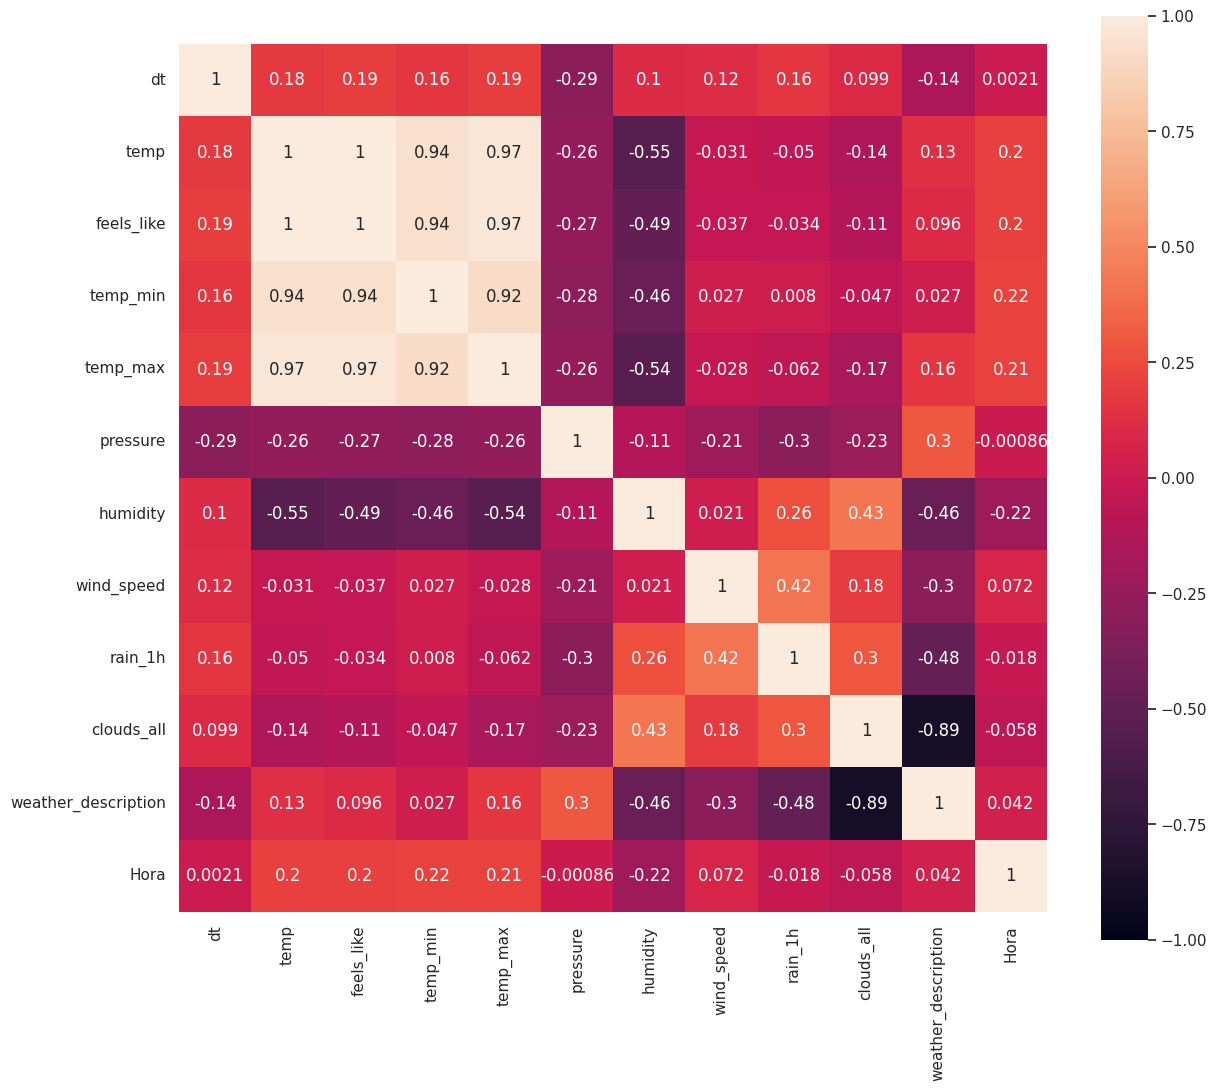

In [ ]:
''''
Correlation meteoDatasets

'''
corr_matrix = meteoDatasets.drop(['dt_iso'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


**drop feature highly correlated**

In [ ]:
meteoDatasets = meteoDatasets.drop(['temp_min', 'temp_max'], axis=1)
test_meteo = test_meteo.drop(['temp_min', 'temp_max'], axis=1)

## Merge train datasets

In [ ]:
# meteoDatasets[['Data','Hora']].to_csv('data_hora_meteo.csv', index=False)

In [ ]:
# energiaDatasets[['Data','Hora']].to_csv('data_hora_energia.csv', index=False)

In [ ]:
energiaDatasets['Data']

0       2021-09-29
1       2021-09-29
2       2021-09-29
3       2021-09-29
4       2021-09-29
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11016, dtype: object

In [ ]:
meteoDatasets['Data']

0       2021-09-01
1       2021-09-01
2       2021-09-01
3       2021-09-01
4       2021-09-01
           ...    
8755    2022-12-31
8756    2022-12-31
8757    2022-12-31
8758    2022-12-31
8759    2022-12-31
Name: Data, Length: 11688, dtype: object

In [ ]:
merged_df = pd.merge(meteoDatasets, energiaDatasets , on=['Data', 'Hora'], how='inner') # inner join para nao haver missing values e começarem ambos na mesma data

In [ ]:
merged_df['Data']

0        2021-09-29
1        2021-09-29
2        2021-09-29
3        2021-09-29
4        2021-09-29
            ...    
11011    2022-12-31
11012    2022-12-31
11013    2022-12-31
11014    2022-12-31
11015    2022-12-31
Name: Data, Length: 11016, dtype: object

<Axes: >

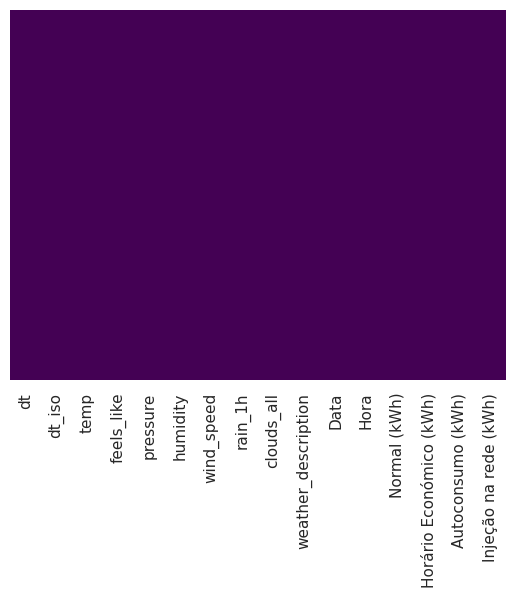

In [ ]:
 sns.heatmap(merged_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

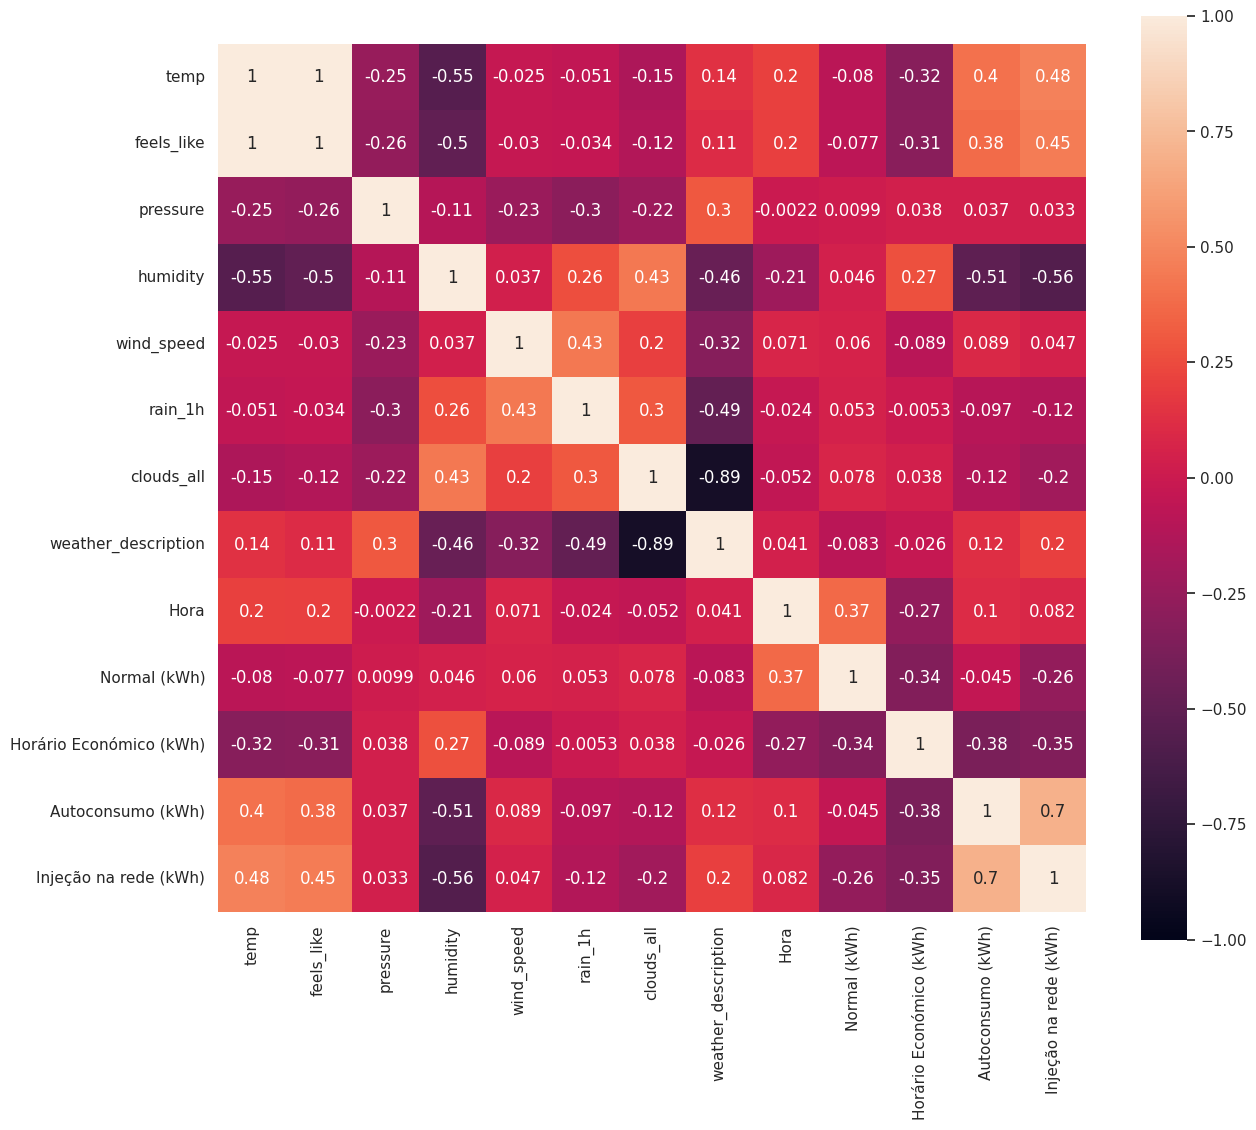

In [ ]:
''''
Correlation

'''
corr_matrix = merged_df.drop(['Data', 'dt', 'dt_iso'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


In [ ]:
'''columns_to_fill = ['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)']

for column in columns_to_fill:
    merged_df[column].fillna(merged_df[column].mean().round(4), inplace=True)

merged_df['Injeção na rede (kWh)'].fillna(merged_df["Injeção na rede (kWh)"].mode()[0], inplace=True)'''

'columns_to_fill = [\'Normal (kWh)\', \'Horário Económico (kWh)\', \'Autoconsumo (kWh)\']\n\nfor column in columns_to_fill:\n    merged_df[column].fillna(merged_df[column].mean().round(4), inplace=True)\n\nmerged_df[\'Injeção na rede (kWh)\'].fillna(merged_df["Injeção na rede (kWh)"].mode()[0], inplace=True)'

In [ ]:
merged_df.to_csv('merged_df.csv', index=False)

nova coluna 'Mes'

In [ ]:
merged_df['Mes'] = pd.DatetimeIndex(merged_df['Data']).month

## Merge test datasets

In [ ]:
test_merged = pd.merge(test_meteo, test_energia , on=['Data', 'Hora'], how='outer')

test_merged.to_csv('test_merged.csv', index=False)
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256 entries, 0 to 2255
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dt                       1752 non-null   float64
 1   dt_iso                   1752 non-null   object 
 2   temp                     1752 non-null   float64
 3   feels_like               1752 non-null   float64
 4   pressure                 1752 non-null   float64
 5   humidity                 1752 non-null   float64
 6   wind_speed               1752 non-null   float64
 7   rain_1h                  1752 non-null   float64
 8   clouds_all               1752 non-null   float64
 9   weather_description      1752 non-null   float64
 10  Data                     2256 non-null   object 
 11  Hora                     2256 non-null   int64  
 12  Normal (kWh)             2256 non-null   float64
 13  Horário Económico (kWh)  2256 non-null   float64
 14  Autoconsumo (kWh)       

In [ ]:
test_merged['Mes'] = pd.DatetimeIndex(test_merged['Data']).month

<Axes: >

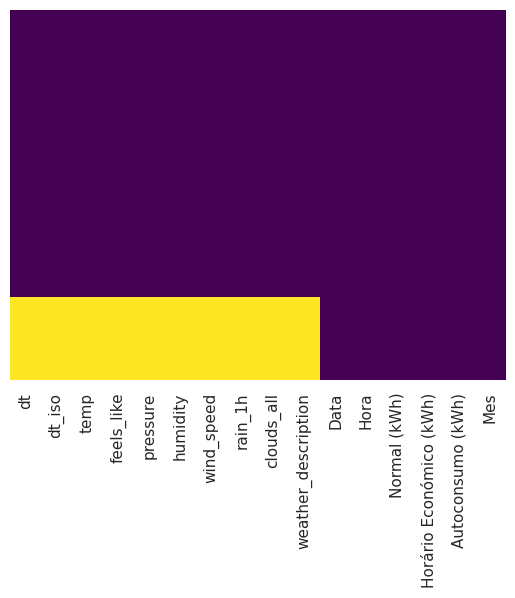

In [ ]:
sns.heatmap(test_merged.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### substituir NaN no merge dos datasets de teste

In [ ]:
'''columns_to_fillna = ['temp','temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h']
test_merged[columns_to_fillna] = test_merged[columns_to_fillna].fillna(test_merged[columns_to_fillna].mean())
columns_to_fillna = ['clouds_all', 'weather_description']

for column in columns_to_fillna:
    mode_value = test_merged[column].mode().iloc[0]  # Get the mode value
    test_merged[column] = test_merged[column].fillna(mode_value) '''

"columns_to_fillna = ['temp','temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h']\ntest_merged[columns_to_fillna] = test_merged[columns_to_fillna].fillna(test_merged[columns_to_fillna].mean())\ncolumns_to_fillna = ['clouds_all', 'weather_description']\n\nfor column in columns_to_fillna:\n    mode_value = test_merged[column].mode().iloc[0]  # Get the mode value\n    test_merged[column] = test_merged[column].fillna(mode_value) "

In [ ]:
wb_df = pd.read_csv('./MissingDataWB.csv', encoding='latin-1',na_filter=False)


In [ ]:
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   app_temp             504 non-null    float64
 1   azimuth              504 non-null    float64
 2   clouds               504 non-null    int64  
 3   datetime             504 non-null    object 
 4   dewpt                504 non-null    float64
 5   dhi                  504 non-null    int64  
 6   dni                  504 non-null    int64  
 7   elev_angle           504 non-null    float64
 8   ghi                  504 non-null    int64  
 9   h_angle              504 non-null    object 
 10  pod                  504 non-null    object 
 11  precip               504 non-null    float64
 12  pres                 504 non-null    int64  
 13  revision_status      504 non-null    object 
 14  rh                   504 non-null    int64  
 15  slp                  504 non-null    int

In [ ]:
wb_df = wb_df[['datetime', 'temp', 'wind_spd', 'clouds', 'pres', 'rh', 'app_temp']]


wb_df[['Data', 'Hora']] = wb_df['datetime'].str.split(':', 1, expand=True)

wb_df['Hora'] = wb_df['Hora'].astype(int)
wb_df = wb_df.drop('datetime',axis=1)

wb_df.rename(columns={"wind_spd": "wind_speed", "clouds": "clouds_all", "pres": "pressure","rh": "humidity", 'app_temp':'feels_like' }, inplace=True) # falta 'weather/description': 'weather_description'

<ipython-input-56-9270e98c39f7>:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  wb_df[['Data', 'Hora']] = wb_df['datetime'].str.split(':', 1, expand=True)
<ipython-input-56-9270e98c39f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb_df[['Data', 'Hora']] = wb_df['datetime'].str.split(':', 1, expand=True)
<ipython-input-56-9270e98c39f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb_df[['Data', 'Hora']] = wb_

In [ ]:
#wb_df['weather_description'].unique()

In [ ]:
'''column_mapping = {
    'weather_description': {'heavy intensity rain': 0, 'moderate rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few Clouds':6, 'Clear Sky':7},
}


for column, mapping in column_mapping.items():
    wb_df[column] = wb_df[column].replace(mapping)'''


"column_mapping = {\n    'weather_description': {'heavy intensity rain': 0, 'moderate rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few Clouds':6, 'Clear Sky':7},\n}\n\n\nfor column, mapping in column_mapping.items():\n    wb_df[column] = wb_df[column].replace(mapping)"

In [ ]:
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        504 non-null    float64
 1   wind_speed  504 non-null    float64
 2   clouds_all  504 non-null    int64  
 3   pressure    504 non-null    int64  
 4   humidity    504 non-null    int64  
 5   feels_like  504 non-null    float64
 6   Data        504 non-null    object 
 7   Hora        504 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 31.6+ KB


In [ ]:
test_merged['temp'].isnull().sum()

504

In [ ]:
wb_df['temp']

0       7.4
1       7.0
2       6.7
3       5.9
4       5.9
       ... 
499    18.9
500    17.0
501    14.4
502    11.5
503    10.4
Name: temp, Length: 504, dtype: float64

In [ ]:
columns_to_fillna = ['temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'feels_like']

if all(col in test_merged.columns and col in wb_df.columns for col in columns_to_fillna):
    # Preencha as últimas 504 linhas do DataFrame 'test_merged' com as linhas do DataFrame 'wb_df'
    for col in columns_to_fillna:
        test_merged.iloc[-504:, test_merged.columns.get_loc(col)] = wb_df[col].values


In [ ]:
test_merged = test_merged.drop(['dt', 'dt_iso', 'weather_description', 'rain_1h'], axis=1)

In [ ]:
test_merged.to_csv('new_test.csv', index=None)

<Axes: >

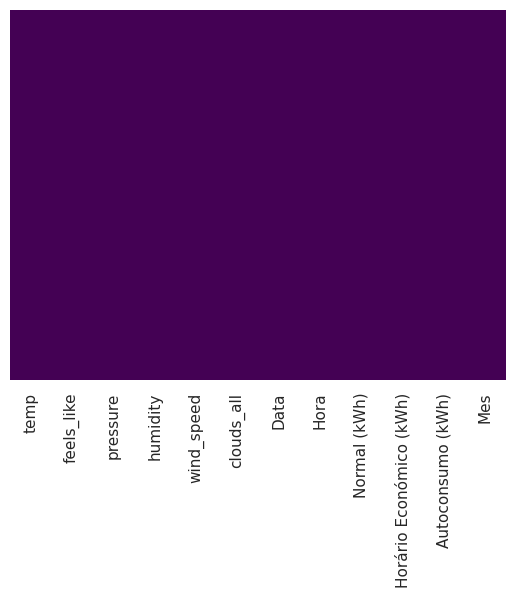

In [ ]:
sns.heatmap(test_merged.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
merged_df=merged_df.drop(['dt_iso', 'weather_description', 'dt', 'rain_1h'],axis=1)
# merged_df=merged_df.drop(['dt_iso', 'dt'],axis=1)

adicionar novas colunas da API WeatherBit
elev_angle -> angulos dos paineis;
solar_rad -> radiação solar;
dni -> direct normal irradiance

In [ ]:
new_data21 = pd.read_csv('./dadosWB21.csv', encoding='latin-1')
new_data22 = pd.read_csv('./dadosWB22.csv', encoding='latin-1')
new_data23 = pd.read_csv('./dadosWB23.csv', encoding='latin-1')

In [ ]:
new_data21['datetime']

0       2021-09-29:00
1       2021-09-29:01
2       2021-09-29:02
3       2021-09-29:03
4       2021-09-29:04
            ...      
2251    2021-12-31:19
2252    2021-12-31:20
2253    2021-12-31:21
2254    2021-12-31:22
2255    2021-12-31:23
Name: datetime, Length: 2256, dtype: object

In [ ]:
new_data22['datetime']

0       2022-01-01:00
1       2022-01-01:01
2       2022-01-01:02
3       2022-01-01:03
4       2022-01-01:04
            ...      
8755    2022-12-31:19
8756    2022-12-31:20
8757    2022-12-31:21
8758    2022-12-31:22
8759    2022-12-31:23
Name: datetime, Length: 8760, dtype: object

In [ ]:
new_data21 = new_data21[['datetime', 'elev_angle']]
new_data22 = new_data22[['datetime', 'elev_angle']]
new_data23 = new_data23[['datetime', 'elev_angle']]

In [ ]:
new_data2122 = pd.merge(new_data21, new_data22 , on=['datetime' , 'elev_angle'], how='outer')

In [ ]:
new_data2122.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11015
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    11016 non-null  object 
 1   elev_angle  11016 non-null  float64
dtypes: float64(1), object(1)
memory usage: 258.2+ KB


In [ ]:
new_data2122['datetime']

0        2021-09-29:00
1        2021-09-29:01
2        2021-09-29:02
3        2021-09-29:03
4        2021-09-29:04
             ...      
11011    2022-12-31:19
11012    2022-12-31:20
11013    2022-12-31:21
11014    2022-12-31:22
11015    2022-12-31:23
Name: datetime, Length: 11016, dtype: object

In [ ]:
new_data2122.to_csv("2122.csv", index=False)

In [ ]:
new_data2122[['Data', 'Hora']] = new_data2122['datetime'].str.split(':', 1, expand=True)

new_data2122['Hora'] = new_data2122['Hora'].astype(int)
new_data2122 = new_data2122.drop('datetime',axis=1)

<ipython-input-75-7cb352d7030f>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  new_data2122[['Data', 'Hora']] = new_data2122['datetime'].str.split(':', 1, expand=True)


In [ ]:
new_data23[['Data', 'Hora']] = new_data23['datetime'].str.split(':', 1, expand=True)
new_data23['Hora'] = new_data23['Hora'].astype(int)
new_data23 = new_data23.drop('datetime',axis=1)

<ipython-input-76-fe393913cfd2>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  new_data23[['Data', 'Hora']] = new_data23['datetime'].str.split(':', 1, expand=True)


In [ ]:
new_data23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   elev_angle  2256 non-null   float64
 1   Data        2256 non-null   object 
 2   Hora        2256 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 53.0+ KB


In [ ]:
new_data2122.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11015
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   elev_angle  11016 non-null  float64
 1   Data        11016 non-null  object 
 2   Hora        11016 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 344.2+ KB


In [ ]:
# adicionar ao dataset de teste
test_merged = test_merged.merge(new_data23, on=['Data','Hora'], how='left')
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256 entries, 0 to 2255
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     2256 non-null   float64
 1   feels_like               2256 non-null   float64
 2   pressure                 2256 non-null   float64
 3   humidity                 2256 non-null   float64
 4   wind_speed               2256 non-null   float64
 5   clouds_all               2256 non-null   float64
 6   Data                     2256 non-null   object 
 7   Hora                     2256 non-null   int64  
 8   Normal (kWh)             2256 non-null   float64
 9   Horário Económico (kWh)  2256 non-null   float64
 10  Autoconsumo (kWh)        2256 non-null   float64
 11  Mes                      2256 non-null   int64  
 12  elev_angle               2256 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 246.8+ KB


In [ ]:
# adicionar ao dataset de treino
merged_df = merged_df.merge(new_data2122, on=['Data','Hora'], how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11015
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     11016 non-null  float64
 1   feels_like               11016 non-null  float64
 2   pressure                 11016 non-null  int64  
 3   humidity                 11016 non-null  int64  
 4   wind_speed               11016 non-null  float64
 5   clouds_all               11016 non-null  int64  
 6   Data                     11016 non-null  object 
 7   Hora                     11016 non-null  int64  
 8   Normal (kWh)             11016 non-null  float64
 9   Horário Económico (kWh)  11016 non-null  float64
 10  Autoconsumo (kWh)        11016 non-null  float64
 11  Injeção na rede (kWh)    11016 non-null  int64  
 12  Mes                      11016 non-null  int64  
 13  elev_angle               11016 non-null  float64
dtypes: float64(7), int64(6

In [ ]:
'''column_mapping = {
    'weather/description': {'Haze': 0, 'Heavy rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few clouds':6, 'Clear Sky':7, 'Thunderstorm with heavy rain':8, 'Moderate rain':9, 'Fog':10 , 'Thunderstorm with heavy rain':11},
}


for column, mapping in column_mapping.items():
    merged_df[column] = merged_df[column].replace(mapping)
    test_merged[column] = test_merged[column].replace(mapping)

    merged_df['weather/description'].astype(int)
    '''

"column_mapping = {\n    'weather/description': {'Haze': 0, 'Heavy rain':1, 'Light rain':2, 'Overcast clouds':3, 'Scattered clouds':4, 'Broken clouds':5, 'Few clouds':6, 'Clear Sky':7, 'Thunderstorm with heavy rain':8, 'Moderate rain':9, 'Fog':10 , 'Thunderstorm with heavy rain':11},\n}\n\n\nfor column, mapping in column_mapping.items():\n    merged_df[column] = merged_df[column].replace(mapping)\n    test_merged[column] = test_merged[column].replace(mapping)\n\n    merged_df['weather/description'].astype(int)\n    "

<Axes: >

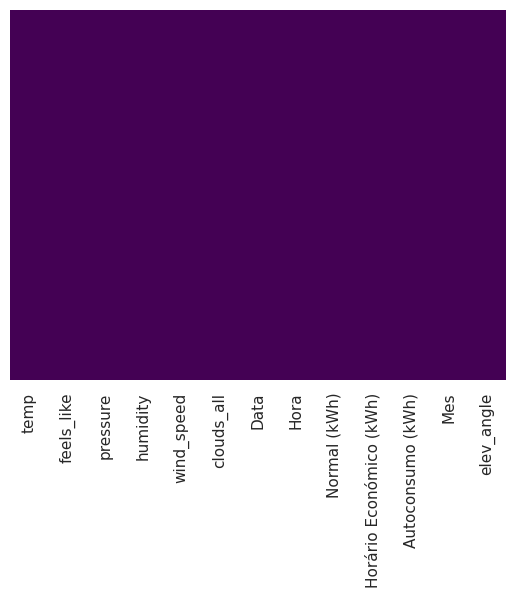

In [ ]:
sns.heatmap(test_merged.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

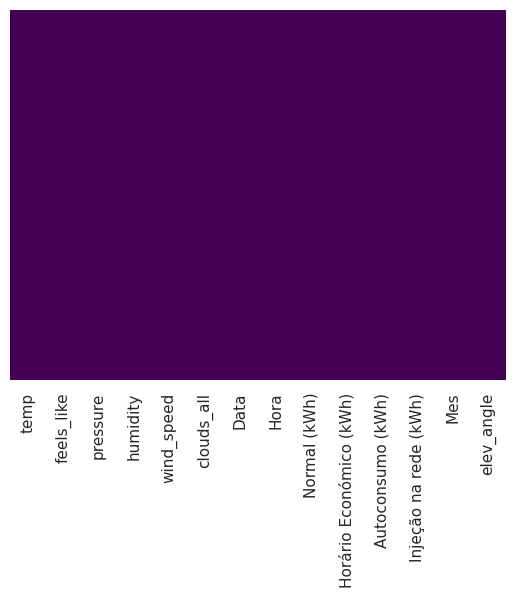

In [ ]:
sns.heatmap(merged_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Outliers

<Axes: ylabel='wind_speed'>

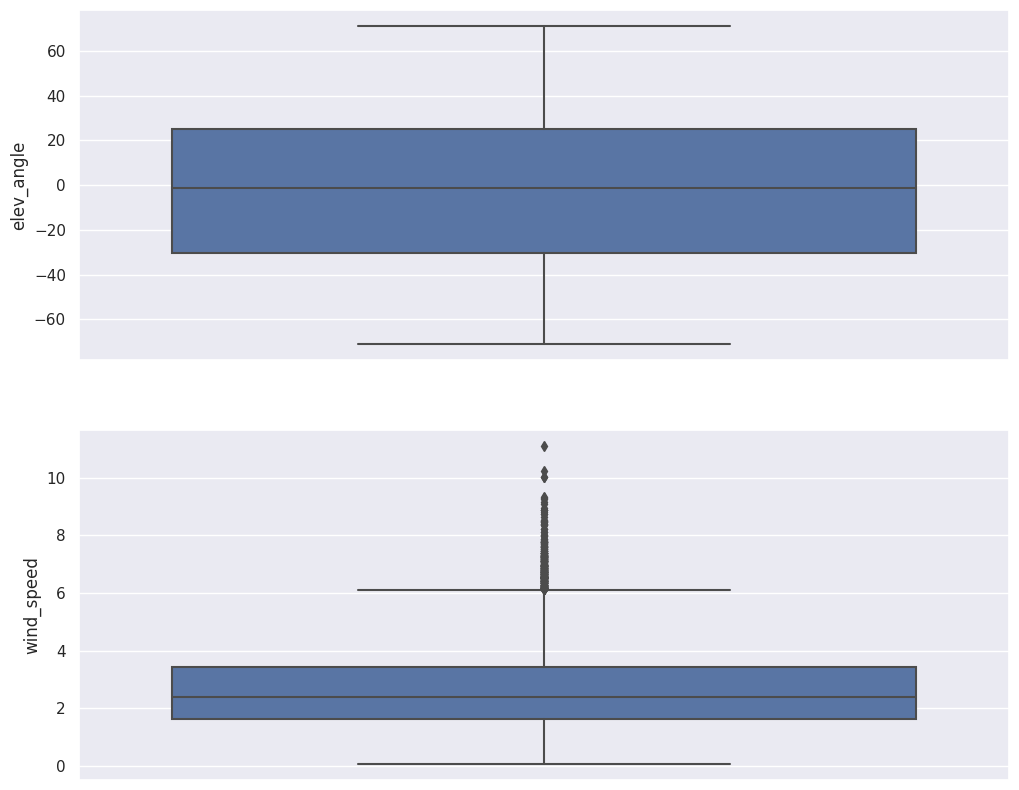

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(12,10))
sns.boxplot(y=merged_df['elev_angle'], ax=axs[0])
sns.boxplot(y=merged_df['wind_speed'], ax=axs[1])

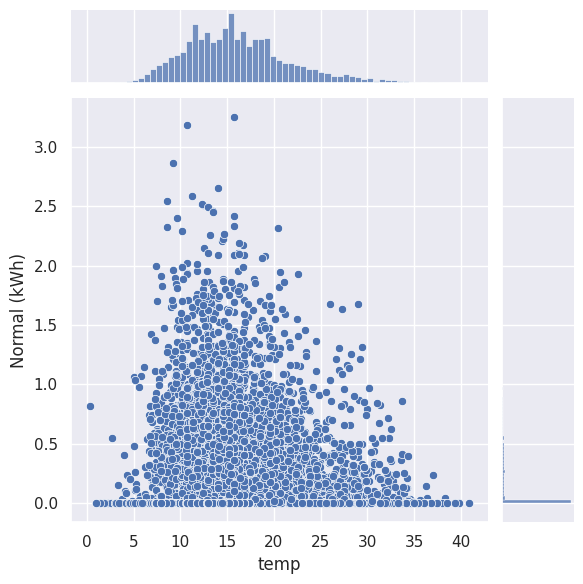

In [ ]:
sns.jointplot(merged_df, x='temp', y='Normal (kWh)')

### Explore the dataset

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11015
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     11016 non-null  float64
 1   feels_like               11016 non-null  float64
 2   pressure                 11016 non-null  int64  
 3   humidity                 11016 non-null  int64  
 4   wind_speed               11016 non-null  float64
 5   clouds_all               11016 non-null  int64  
 6   Data                     11016 non-null  object 
 7   Hora                     11016 non-null  int64  
 8   Normal (kWh)             11016 non-null  float64
 9   Horário Económico (kWh)  11016 non-null  float64
 10  Autoconsumo (kWh)        11016 non-null  float64
 11  Injeção na rede (kWh)    11016 non-null  int64  
 12  Mes                      11016 non-null  int64  
 13  elev_angle               11016 non-null  float64
dtypes: float64(7), int64(6

<Axes: >

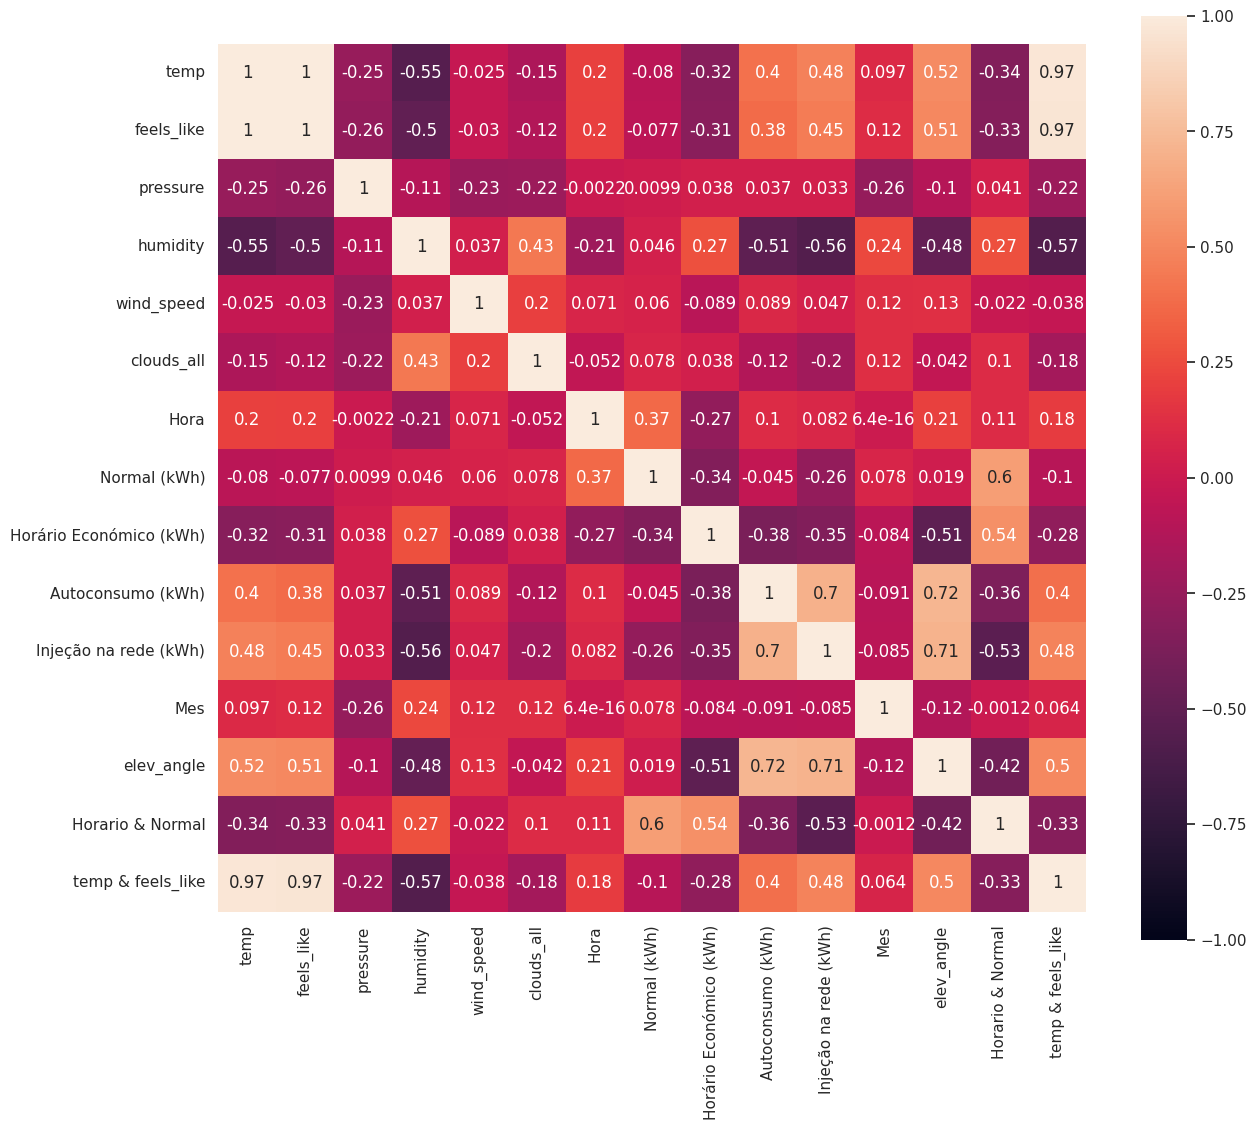

In [ ]:
''''
Correlation

'''
merged_df['Horario & Normal'] = merged_df['Horário Económico (kWh)']*0.55 + merged_df['Normal (kWh)']*0.45
merged_df['temp & feels_like'] = merged_df['temp'] * merged_df['feels_like']
test_merged['Horario & Normal'] = test_merged['Horário Económico (kWh)']*0.55 + test_merged['Normal (kWh)']*0.45
test_merged['temp & feels_like'] = test_merged['temp'] * test_merged['feels_like']
corr_matrix = merged_df.drop(['Data'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


In [ ]:
# drop 'AutoConsumo'
#merged_df = merged_df.drop(['Autoconsumo (kWh)'], axis=1)
#test_merged = test_merged.drop(['Autoconsumo (kWh)'], axis=1)

nova coluna 'tempHum':
Esta nova coluna irá relacionar a temperatura em graus com a % de humidade sentida nesse dia

In [ ]:
'''merged_df['tempHum'] =  round(merged_df['temp'] - (merged_df['temp'] * (merged_df['humidity'] / 100.0)), 2)'''

"merged_df['tempHum'] =  round(merged_df['temp'] - (merged_df['temp'] * (merged_df['humidity'] / 100.0)), 2)"

In [ ]:
'''test_merged['tempHum'] =  round(test_merged['temp'] - (test_merged['temp'] * (test_merged['humidity'] / 100.0)), 2)'''

"test_merged['tempHum'] =  round(test_merged['temp'] - (test_merged['temp'] * (test_merged['humidity'] / 100.0)), 2)"

voltar a passar os dados para categoricos

In [ ]:
'''column_mapping = {
    'Injeção na rede (kWh)': {0: 'None', 1:'Low',2: 'Medium', 3: 'High', 4:'Very High'},
}
for column, mapping in column_mapping.items():
    merged_df[column] = merged_df[column].map(mapping)

merged_df.head()'''

"column_mapping = {\n    'Injeção na rede (kWh)': {0: 'None', 1:'Low',2: 'Medium', 3: 'High', 4:'Very High'},\n}\nfor column, mapping in column_mapping.items():\n    merged_df[column] = merged_df[column].map(mapping)\n\nmerged_df.head()"

## Algoritmos

In [ ]:
df = merged_df.copy()

### Support Vector Machine

In [ ]:
'''df_svm=pd.DataFrame(data=merged_df)
df_svm.head()'''

'df_svm=pd.DataFrame(data=merged_df)\ndf_svm.head()'

In [ ]:
#df_svm = df_svm.drop(['dt','dt_iso', 'Data'],  axis=1)

In [ ]:
'''
scale variables in 0 to 1 because SVM is sensitive to scale

df_svm = (df_svm - df_svm.min()) / (df_svm.max() - df_svm.min())
df_svm.head()
'''


'\nscale variables in 0 to 1 because SVM is sensitive to scale\n\ndf_svm = (df_svm - df_svm.min()) / (df_svm.max() - df_svm.min())\ndf_svm.head()\n'

In [ ]:
'''X_train = df_svm.drop(['Injeção na rede (kWh)', 'wind_speed','Hora','pressure'], axis=1)
X_test = test_merged.drop(['Data', 'wind_speed','Hora','pressure'], axis=1)
y_train = df_svm['Injeção na rede (kWh)']'''

"X_train = df_svm.drop(['Injeção na rede (kWh)', 'wind_speed','Hora','pressure'], axis=1)\nX_test = test_merged.drop(['Data', 'wind_speed','Hora','pressure'], axis=1)\ny_train = df_svm['Injeção na rede (kWh)']"

In [ ]:
#scale
'''from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)
'''

'from sklearn.preprocessing import MinMaxScaler\n\nminmax_scaler = MinMaxScaler()\nX_train_minmax = minmax_scaler.fit_transform(X_train)\nX_test_minmax = minmax_scaler.transform(X_test)\n'

In [ ]:
'''from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#h1=svm.LinearSVC(C=1) # c=1 hyperparameters without gridsearch
param_grid = {'C': [0.1,1,10,100,1000], 'gamma':[1,0.1,0.01, 0.001, 0.0001], 'kernel':['rbf']}'''

"from sklearn.svm import SVC\nfrom sklearn.model_selection import GridSearchCV\n\n#h1=svm.LinearSVC(C=1) # c=1 hyperparameters without gridsearch\nparam_grid = {'C': [0.1,1,10,100,1000], 'gamma':[1,0.1,0.01, 0.001, 0.0001], 'kernel':['rbf']}"

In [ ]:
#grid = GridSearchCV(SVC(random_state=2021), param_grid, refit=True, verbose=3)

In [ ]:
'''label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)'''

'label_encoder = LabelEncoder()\ny_train_encoded = label_encoder.fit_transform(y_train)'

In [ ]:
#grid.fit(X_train_minmax,y_train)

In [ ]:
#grid.best_params_

In [ ]:
#predictions=grid.predict(X_test_minmax)

### Random Forest

In [ ]:
random_forest = merged_df.copy()

In [ ]:
'''X_train = random_forest.drop(['Injeção na rede (kWh)','Data'], axis=1)
X_test = test_merged.drop(['Data'], axis=1)
y_train = random_forest['Injeção na rede (kWh)']'''

"X_train = random_forest.drop(['Injeção na rede (kWh)','Data'], axis=1)\nX_test = test_merged.drop(['Data'], axis=1)\ny_train = random_forest['Injeção na rede (kWh)']"

In [ ]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [80, 90, 100, 110],
    'max_features': [3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)'''

"from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\nparam_grid = {\n    'bootstrap': [True, False],\n    'criterion': ['gini', 'entropy'],\n    'max_depth': [80, 90, 100, 110],\n    'max_features': [3, 4],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [8, 10, 12],\n    'n_estimators': [100, 200, 300, 1000]\n}\nrf = RandomForestClassifier()\n\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid,\n                          cv = 3, n_jobs = -1, verbose = 2)"

In [ ]:
'''
X = np.array(random_forest.drop(['Injeção na rede (kWh)', 'Hora', 'Data'], axis=1) )
y = np.array(random_forest['Injeção na rede (kWh)'])
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.3)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [100, 200],
    'max_features': [4,5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8,10,12],
    'n_estimators': [1000]
}
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

from sklearn.metrics import accuracy_score
acc = metrics.accuracy_score(y_test, predictions)
acc
'''

"\nX = np.array(random_forest.drop(['Injeção na rede (kWh)', 'Hora', 'Data'], axis=1) )\ny = np.array(random_forest['Injeção na rede (kWh)'])\nX_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.3)\n\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\n\nparam_grid = {\n    'bootstrap': [True, False],\n    'criterion': ['gini', 'entropy'],\n    'max_depth': [100, 200],\n    'max_features': [4,5],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [8,10,12],\n    'n_estimators': [1000]\n}\nrf = RandomForestClassifier()\n\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid,\n                          cv = 3, n_jobs = -1, verbose = 2)\n\ngrid_search.fit(X_train, y_train)\n\nrf.fit(X_train, y_train)\n\npredictions = rf.predict(X_test)\n\nfrom sklearn.metrics import accuracy_score\nacc = metrics.accuracy_score(y_test, predictions)\nacc\n"

In [ ]:
#best_rf = grid_search.best_estimator_

In [ ]:

'''feature_importances = best_rf.feature_importances_
train_predictions = best_rf.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_predictions = best_rf.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)'''

'feature_importances = best_rf.feature_importances_\ntrain_predictions = best_rf.predict(X_train)\ntrain_accuracy = metrics.accuracy_score(y_train, train_predictions)\ntest_predictions = best_rf.predict(X_test)\ntest_accuracy = metrics.accuracy_score(y_test, test_predictions)'

In [ ]:
#grid_search.fit(X_train, y_train)

In [ ]:
#grid_search.best_params_

In [ ]:
#predictions=grid_search.predict(X_test)

### Ensemble Learning - boosting

In [ ]:
X_train = df.drop(['Injeção na rede (kWh)','Data','temp','feels_like'], axis=1)
X_test = test_merged.drop(['Data', 'temp', 'feels_like'], axis=1)
y_train = df['Injeção na rede (kWh)'].astype(int)

In [ ]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
11011    0
11012    0
11013    0
11014    0
11015    0
Name: Injeção na rede (kWh), Length: 11016, dtype: int64

In [ ]:
'''from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)'''

'from sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nparameters = {\n    "loss":["deviance"],\n    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],\n    "min_samples_split": np.linspace(0.1, 0.5, 12),\n    "min_samples_leaf": np.linspace(0.1, 0.5, 12),\n    "max_depth":[3,5,8],\n    "max_features":["log2","sqrt"],\n    "criterion": ["friedman_mse",  "mae"],\n    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],\n    "n_estimators":[10]\n    }\n\nclf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)'

In [ ]:
#clf.fit(X_train, y_train)

In [ ]:
#print(clf.score(X_train, y_train))

In [ ]:
#print(clf.best_params_)

In [ ]:
# Predict on test set
#predictions = clf.predict(X_test)

###**XdgBoosting**

In [ ]:
from xgboost import XGBClassifier
#xgb = XGBClassifier(max_depth=1, objective='reg:squarederror')
xgb = XGBClassifier(learning_rate=0.02, n_estimators=200, objective='multi:softmax',num_class=5,
                    silent=True)

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1,3,5]
        }

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', verbose=3, refit=True )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11016 entries, 0 to 11015
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp                     11016 non-null  float64
 1   feels_like               11016 non-null  float64
 2   pressure                 11016 non-null  int64  
 3   humidity                 11016 non-null  int64  
 4   wind_speed               11016 non-null  float64
 5   clouds_all               11016 non-null  int64  
 6   Data                     11016 non-null  object 
 7   Hora                     11016 non-null  int64  
 8   Normal (kWh)             11016 non-null  float64
 9   Horário Económico (kWh)  11016 non-null  float64
 10  Autoconsumo (kWh)        11016 non-null  float64
 11  Injeção na rede (kWh)    11016 non-null  int64  
 12  Mes                      11016 non-null  int64  
 13  elev_angle               11016 non-null  float64
 14  Horario & Normal      

In [ ]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.803 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.804 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.843 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.804 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.822 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.854 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.876 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.854 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.872 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.861 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:04:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.820 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.849 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.870 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.856 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.874 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.857 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.869 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.879 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.850 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.884 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.866 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.872 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.877 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.857 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.883 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.830 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.837 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.884 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.875 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.833 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.837 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.870 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.890 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.875 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.832 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.833 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.892 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.829 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.842 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.870 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.885 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:05:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.831 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.843 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.870 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.887 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.874 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.839 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.889 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.843 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.871 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.879 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.842 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.884 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.834 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.843 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.875 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.886 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.803 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.853 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.875 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.820 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.855 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.871 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.851 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.870 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.886 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.857 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.875 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.856 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.870 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.821 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.851 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.869 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.884 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.866 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.872 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.858 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.867 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.882 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.830 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.839 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.871 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.887 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.832 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.837 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.871 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.889 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.874 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.832 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.833 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:07:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.891 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.871 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.831 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.845 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.870 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.885 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.831 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.843 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.870 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.886 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.840 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.891 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.832 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.844 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.880 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.843 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.873 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.884 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.843 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.876 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.884 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.870 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.803 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:08:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.804 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.854 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.874 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.821 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.855 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.871 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.821 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.850 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.870 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.857 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.866 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.873 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.861 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.821 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.856 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.869 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.851 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.885 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.866 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.871 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.861 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.869 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.878 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.820 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.884 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.831 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.840 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.872 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.887 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.831 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.840 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.890 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:09:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.873 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.832 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.835 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.891 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.832 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.845 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.886 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.832 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.843 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.870 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.885 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.838 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.890 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.873 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.844 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.871 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.879 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.844 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.882 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.843 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.873 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.886 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.804 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:10:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.803 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.804 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.804 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.845 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.817 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.865 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.873 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.870 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.858 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.817 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.863 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.863 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.871 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.819 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.862 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.869 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.878 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.819 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.860 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.883 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.859 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.818 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.870 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.863 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.818 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.877 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.819 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.861 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.867 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.882 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.886 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:11:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.871 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.850 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.889 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.871 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.851 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.873 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.891 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.828 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.846 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.871 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.884 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.871 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.849 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.871 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.884 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.851 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.873 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.886 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.852 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.879 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.870 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.852 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.887 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.872 total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.853 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.874 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.883 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.840 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.841 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.854 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.854 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.842 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.854 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.855 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.862 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.877 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.854 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.880 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.824 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.848 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.886 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.858 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.876 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.856 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.825 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.850 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.868 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.885 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.865 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.873 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.858 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.825 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.857 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.883 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.833 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.842 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:13:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.867 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.888 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.875 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.833 total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.840 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.867 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.889 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.875 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.836 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.837 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.865 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.888 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.873 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.833 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.850 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.885 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.834 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.844 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.887 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.875 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.838 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.841 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.868 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.888 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.850 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.868 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.879 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.846 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.868 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.884 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.840 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.846 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.872 total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.883 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.854 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.842 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.808 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.822 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.854 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.854 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.856 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.864 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.877 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.827 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.854 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.824 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.850 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.884 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.860 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.875 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.828 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.856 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.825 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.850 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.884 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.826 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.864 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.873 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.863 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.881 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.858 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.825 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.857 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.883 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.859 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.833 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.842 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.870 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.889 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.834 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.842 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.869 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.888 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.835 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.839 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.867 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.889 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.833 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.849 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.869 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.885 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.834 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.844 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.868 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.873 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.841 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.868 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.887 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.873 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.848 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.868 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.880 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:16:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.845 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.884 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.873 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.839 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.847 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.881 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.871 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.822 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.854 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.809 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.854 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.840 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.841 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.854 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.857 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.877 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.856 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.880 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.825 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.852 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:17:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.876 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.826 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.857 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.825 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.851 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.868 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.884 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.873 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.859 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.863 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.881 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.826 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.883 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.833 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.842 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.889 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.833 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.841 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.869 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.875 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.835 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.840 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.871 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.834 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.851 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.883 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.872 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.834 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:18:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.846 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.886 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.840 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.870 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.886 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.872 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.835 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.849 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.878 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.873 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.835 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.845 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.884 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.874 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.837 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.847 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.880 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.840 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.841 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.854 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.854 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.808 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.842 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.840 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.841 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.808 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.854 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.842 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.827 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.862 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.876 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.825 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.863 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.858 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.873 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.858 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.827 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.880 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.858 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.824 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.859 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.863 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.883 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.826 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.863 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.871 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.859 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.826 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.878 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.859 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.825 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.882 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.858 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.830 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.851 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.868 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.887 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.875 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.831 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.854 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.866 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.887 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.829 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.861 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.868 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.886 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:20:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.875 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.831 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.853 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.869 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.884 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.832 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.851 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.867 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.885 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.830 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.858 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.866 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.886 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.875 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.830 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.849 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.867 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.878 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.874 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.854 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.869 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.882 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.875 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.831 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.865 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.882 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=0.8, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.874 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.844 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.809 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.809 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:21:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.830 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.850 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.876 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.864 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.828 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.850 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.883 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.851 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.868 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.852 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.877 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.852 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.882 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.862 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.847 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.884 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.870 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.859 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.881 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.857 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.865 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.883 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.832 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.842 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:22:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.869 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.888 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.874 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.836 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.840 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.867 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.890 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.871 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.840 total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.845 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.864 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.884 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.868 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.834 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.847 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.870 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.887 total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.873 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.836 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.841 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.872 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.869 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.836 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.845 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.867 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.889 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.865 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.836 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.844 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.883 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.872 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.835 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.841 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.867 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.883 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.869 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.838 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.841 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.882 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:23:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.870 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.809 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.844 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.830 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.850 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.875 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.851 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.863 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.882 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.851 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.868 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.883 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.826 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.853 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.875 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.861 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.825 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.855 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.882 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:24:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.849 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.885 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.827 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.859 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.871 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.881 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.857 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.865 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.883 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.832 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.839 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.869 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.889 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.872 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.837 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.842 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.867 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.887 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.870 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.837 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.842 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.869 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.886 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.869 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.834 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.845 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.868 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.885 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.837 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.841 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.872 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.869 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.835 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:25:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.845 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.870 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.867 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.836 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.843 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.868 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.882 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.873 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.835 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.841 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.881 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.871 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.837 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.842 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.868 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.882 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.868 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.809 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.844 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.809 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.809 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.844 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.837 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.830 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.850 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:26:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.875 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.863 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.853 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.863 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.882 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.851 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.866 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.883 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.826 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.857 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.875 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.854 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.883 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.849 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.883 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.828 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.825 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.881 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.824 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.857 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.864 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.882 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.832 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.840 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.870 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.888 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.873 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.835 total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.840 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.868 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.888 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.869 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.838 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.840 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.872 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.884 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.867 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.833 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.845 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.869 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.883 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.837 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.842 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.869 total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.887 total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.867 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.834 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.843 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.870 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.887 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.868 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.837 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.845 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.867 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.882 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.874 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.835 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.840 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.865 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.880 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.872 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.838 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.842 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.869 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.882 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.869 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.823 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=1, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.821 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:28:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.809 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.823 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=5, subsample=1.0;, score=0.844 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.809 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.821 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.837 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.847 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.6;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.810 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.822 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.848 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=0.8;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.809 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.823 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.843 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=1, min_child_weight=10, subsample=1.0;, score=0.844 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.827 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.860 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.857 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.881 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.828 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.867 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.885 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.861 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.827 total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.872 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.824 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.881 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=0.8;, score=0.861 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.828 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.867 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.882 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.829 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.860 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.858 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.869 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.862 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.823 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.859 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.879 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.861 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.826 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.861 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.862 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.881 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=1.0;, score=0.860 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.851 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.882 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.6;, score=0.875 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.833 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.852 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.866 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.882 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=0.8;, score=0.873 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.858 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.870 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.882 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=1, subsample=1.0;, score=0.868 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.832 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.852 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.879 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.6;, score=0.877 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.852 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.865 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.878 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=0.8;, score=0.872 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.857 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.870 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.879 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=0.867 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.847 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.867 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.878 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.6;, score=0.874 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.833 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.850 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.867 total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.882 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.871 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.831 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.856 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.868 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.881 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=5, min_child_weight=10, subsample=1.0;, score=0.869 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:30:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_class=5,
                                     num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 5], 'max_depth': [1, 3, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=3)

In [ ]:
grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 1.0}

In [ ]:
predictions = grid.predict(X_test)

In [ ]:
mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
mapped_predictions = np.vectorize(mapping.get)(predictions)
mapped_predictions = np.array(mapped_predictions)

In [ ]:
predicted_labels = [mapping[prediction] for prediction in predictions]

## SUBMISSAO

In [ ]:
test_merged['RowId'] = test_merged.index + 1

In [ ]:
submission = pd.DataFrame({
    'RowId': test_merged['RowId'],
    'Result': predicted_labels
})


In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256 entries, 0 to 2255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   RowId   2256 non-null   int64 
 1   Result  2256 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.9+ KB


In [ ]:
submission.to_csv('submission.csv', index=None)

In [ ]:
df.to_csv('bruh.csv', index=None)